<a href="https://colab.research.google.com/github/VKSi/2021_02_GB_PyTorch/blob/main/HW_3_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> “Фреймворк PyTorch для разработки искусственных нейронных сетей”</center></h1>

# GAN (Generative Adversarial Network)
## Генеративно-состязательная нейросеть


** Домашнее задание: **

1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю
 

2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.


## Подготовка окружения

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/PyTorch/'
PATH_L3 = PATH + 'Lesson3/'
DATA_PATH = PATH + 'data/'

In [ ]:
import os
import numpy as np
import pandas as pd
import math

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

## Функции из предоставленного ноутбука   

In [ ]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], PATH_L3 + "images_%d.png" % batches_done, nrow=5, normalize=True)

Параметры для обучения обеих моделей

In [ ]:
n_epochs = 200
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

Генератор

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их
                                                    # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # Эта сторчка означает тоже самое что и
                                                       # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


Дискриминатор:

In [ ]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса кка параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные на трнспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [ ]:
d_loss_history = []
g_loss_history = []

Загрузка датасета     
Его уже загружали в первом ДЗ

In [ ]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        DATA_PATH,
        train=True,
        download=False,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

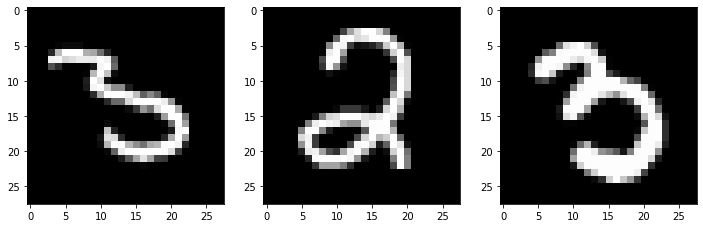

In [ ]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])
img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

Инициализация

Процесс обучения:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 199/200] [Batch 913/938] [D loss: 0.489780] [G loss: 1.247719]


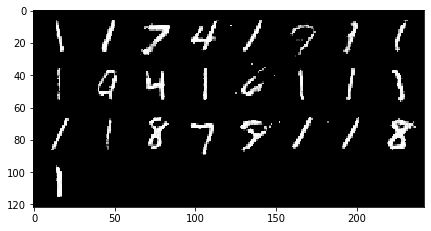

<Figure size 432x288 with 0 Axes>

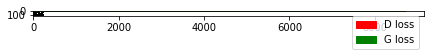

In [ ]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                sample_image(gen_imgs)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 


                display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
                plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
                plt.legend(handles=[red_patch, green_patch])
                plt.show()

            

## Задача 1

Я масштабировал функцию для удобства дальнейших преобразований

In [ ]:
def func_y(x):
  x1 = x - 14
  return 10*(np.sin(x1)/x1 - x1/10) + 14

Строим нерперывный вариант

In [ ]:
x_min = 0
x_max = 28
x_real = np.linspace(x_min, x_max, 10000)
y_real = func_y(x_real)

x_noise = np.random.uniform(x_min, x_max, 10000)
y_noise = np.random.uniform(func_y(x_min), func_y(x_max), 10000)

def cleaner(x, y, delta, drop_keep):
  to_drop = []
  for i in range(len(x)):
    if (np.abs(func_y(x[i]) - y[i]) < delta) == drop_keep:
      to_drop.append(i)
  x =np.delete(x, to_drop)
  y =np.delete(y, to_drop)
  print(len(to_drop))
  return x, y

delta = 10**(-3)

x_real, y_real = cleaner(x_real, y_real, delta, False)
x_noise, y_noise = cleaner(x_noise, y_noise, delta, True)

0
0


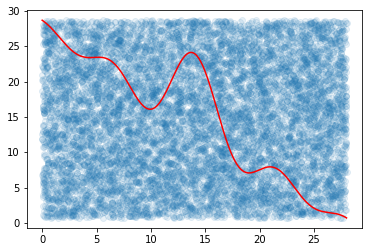

In [ ]:
plt.scatter(x_noise, y_noise, alpha=0.1)
plt.plot(x_real, y_real, c='red')
plt.show()

Строим дискретный вариант для преобразовани в картинки

In [ ]:
x_min = 0
x_max = 28
x_real = np.array(range(x_min, x_max, 1))
y_real = func_y(x_real)
nan_ind = np.argwhere(np.isnan(y_real))
x_real = np.delete(x_real, nan_ind)
y_real = np.delete(y_real, nan_ind)
y_real = np.floor(y_real) - 1

print(len(x_real))

x_noise = np.random.randint(x_min, x_max, 10000)
y_noise = np.random.randint(func_y(x_max), func_y(x_min), 10000)
nan_ind = np.argwhere(np.isnan(y_noise))
x_noise = np.delete(x_noise, nan_ind)
y_noise = np.delete(y_noise, nan_ind)
y_noise = np.floor(y_noise)

def cleaner(x, y, delta, drop_keep):
  to_drop = []
  for i in range(len(x)):
    if (np.abs(func_y(x[i]) -1 - y[i]) < delta) == drop_keep:
      to_drop.append(i)
  x =np.delete(x, to_drop)
  y =np.delete(y, to_drop)
  print(len(to_drop))
  return x, y

delta = 1

x_real, y_real = cleaner(x_real, y_real, delta, False)
x_noise, y_noise = cleaner(x_noise, y_noise, delta, True)

27
0
656


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


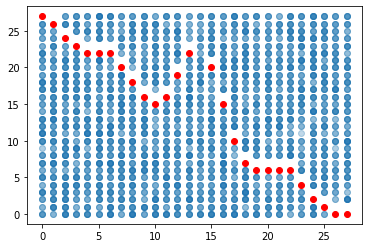

In [ ]:
plt.scatter(x_noise, y_noise, alpha=0.1)
plt.scatter(x_real, y_real, c='red')
plt.show()

Преобразуем в картинки

In [ ]:
class_1_imgs = np.zeros((len(x_real), 28, 28))
for i in range(len(x_real)):
  im = np.zeros((28, 28))
  im[int(x_real[i])][int(y_real[i])] = 1
  class_1_imgs[i] = im

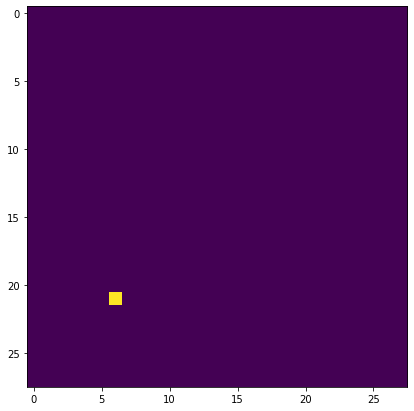

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(class_1_imgs[20], interpolation="nearest")

In [ ]:
class_0_imgs = np.zeros((len(x_noise), 28, 28))
for i in np.nditer(x_noise):
  im = np.zeros((28, 28))
  im[int(x_noise[i])][int(y_noise[i])] = 1
  class_0_imgs[i] = im

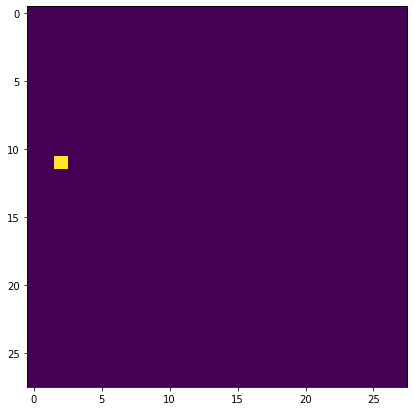

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(class_0_imgs[22], interpolation="nearest")

In [ ]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

Функция подготовки данных

In [ ]:
def get_data(class_1_imgs):  # class_0_imgs, 
  labels = {1:1}  # labels = {0:0, 1:1}
  # df_noise = pd.DataFrame(class_0_imgs.reshape(len(class_0_imgs), -1))
  # df_noise['labels'] = 0
  df_real = pd.DataFrame(class_1_imgs.reshape(len(class_1_imgs), -1))
  df_real['labels'] = 1
  # df = pd.concat([df_noise, df_real])
  df = df_real.sample(frac=1)  # df = df.sample(frac=1)
  df.reset_index(inplace=True, drop = True)
  return df, labels

In [ ]:
dft, labels = get_data(class_1_imgs)  # get_data(class_0_imgs, class_1_imgs)
print(labels)
print(dft.shape)
print(dft.iloc[1, :].sum())
dft.head()

{1: 1}
(27, 785)
2.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Класс Dataset

In [ ]:
class Bogdan_Function_Dataset(Dataset):
    def __init__(self, class_1_imgs, filter_params, transform=None):  # class_0_imgs, 
        self.data, self.labels = get_data(class_1_imgs)  # class_0_imgs, 
        self.transform = transform
        self.filter_params = filter_params
        self.labels = self.data.iloc[:,-1]


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1])
        label = self.labels[idx]
        if self.transform != None:
            item = self.transform(item)
        return (item, label) 

In [ ]:
dataset = Bogdan_Function_Dataset(class_1_imgs, filter_params = {}, transform=None)  # class_0_imgs, 

In [ ]:
item, label = dataset.__getitem__(22)
print('item: ', item)
print('label: ', label)

item:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0

In [ ]:
item.sum()

1.0

Обучение

In [ ]:
n_epochs = 800
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 2
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)), len(dataset) - int(0.75*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [ ]:
real_data = train_loader

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [ ]:
d_loss_history = []
g_loss_history = []

In [ ]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                # plt.clf()

                display.clear_output(wait=False)
                # sample_image(gen_imgs)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 
                # display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)


[Epoch 775/800] [Batch 0/1] [D loss: 0.173857] [G loss: 2.249329]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


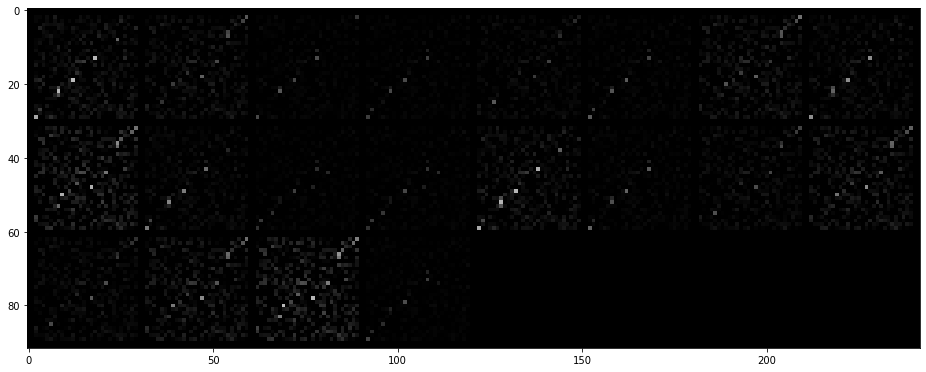

In [ ]:
sample_image(gen_imgs)

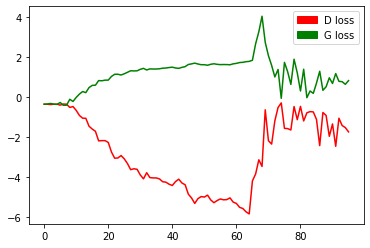

In [ ]:
plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
plt.legend(handles=[red_patch, green_patch])
plt.show()